# Implementing neural networks

Today, we're going to go through the process together of implementing a neural network for a simple regression problem.  Then I'm going to turn you loose to adapt this methodology to the MNIST problem.

We're going to use a new library to implement this network.  This library is called pytorch, and you can easily install it by following the installation instructions found [here](https://pytorch.org/get-started/locally/).  Why are we not using numpy?  We'll return to that in a moment.  However, torch actually behaves significantly like numpy in a variety of ways.  For example we can generate a synthetic dataset (rather similar to that from Homework 2) using some familiar commands:


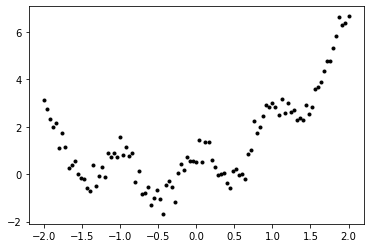

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generate the features
x = torch.linspace(-2,2,101).reshape(-1,1)

# Generate the response variables 
y_obs = x**2 + x + torch.cos(2*np.pi*x) + torch.randn_like(x)*0.3

plt.plot(x,y_obs,'k.')

We'd like to find a function that fits this data.  One way to do this is, of course, linear regression, but that requires specifying the form of the design matrix.  As we saw in lecture, we'd like to learn the design matrix from the data.  We'll use a neural network to perform this task.  Algebraically, we can specify the neural network via the following sequentially applied functions.
$$
\underbrace{z}_{m\times p} = \underbrace{x}_{m\times 1} \underbrace{W^{(1)}}_{1\times p} + \underbrace{b^{(1)}}_{1\times p}
$$
$$
h = \sigma(z)
$$
$$
\underbrace{y}_{m\times 1} = h \underbrace{W^{(2)}}{p \times 1} + \underbrace{b^{(2)}}_{1\times 1}
$$

Because this is getting a bit complicated, let's develop a create a class for this neural network to hold weights and apply functions as appropriate.    

In [2]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10
        self.W_2 = torch.randn(p,N)/np.sqrt(p)
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10
        self.b_2 = torch.randn(1,N)/np.sqrt(p)
               
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        
        return self.y


You'll notice that we're instantiating weights randomly.  Let's see what type of functions this model produces, prior to training.  It's interesting to see what the effect is of messing with the variance of the weights when initializing them.   

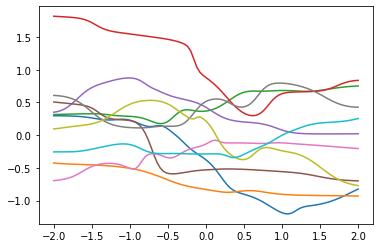

In [3]:
# Sample 10 random neural nets
for i in range(10):
    
    # Create the neural network
    net = NeuralNet(1,20,1)
    
    # Make a prediction
    y_pred = net.forward(x)
    
    # Plot the predictions
    plt.plot(x,y_pred)


Of course, this isn't all that interesting on its own.  We now need to train this thing.  We'll do this using gradient descent, and herein lies the power of pytorch.  It is a framework for *automatic differentiation*.  What does this mean?  It means that it keeps a record of all of the operations that have been done to produce the output of a given function.  It then can *automaticall* apply the chain rule to produce derivatives of a function with respect to anything that was used to compute it.  Here, we're hoping to take the gradient with respect to the weights and biases.  We can tell pytorch that we're going to want these things by using the "requires_grad_" flag.  

In [4]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10
        self.W_2 = torch.randn(p,N)/np.sqrt(p)
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10
        self.b_2 = torch.randn(1,N)/np.sqrt(p)
        
        ### CHANGE FROM ABOVE ###  
        # Collect the model parameters, and tell pytorch to
        # collect gradient information about them.
        self.parameters = [self.W_1,self.W_2,self.b_1,self.b_2]
        for param in self.parameters:
            param.requires_grad_()
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        return self.y
    
    def zero_grad(self):
        ### Each parameter has an additional array associated
        ### with it to store its gradient.  This is not 
        ### automatically cleared, so we have a method to
        ### clear it.
        for param in self.parameters:
            try:
                param.grad.data[:] = 0.0
            except AttributeError:
                pass
        

One thing that still need is something to minimize.  Since this is a regression problem, we'll use mean-squared-error

In [5]:
def mse(y_pred,y_obs):
    m = y_pred.shape[0]
    return 1./m*((y_pred-y_obs)**2).sum()

Now, the code for gradient descent becomes strikingly simple:

In [6]:
net = NeuralNet(1,20,1)  # Instantiate network
eta = 1e-1               # Set learning rate (empirically derived)
for t in range(50000):   # run for 50000 epochs
    y_pred = net.forward(x)   # Make a prediction
    L = mse(y_pred,y_obs)     # Compute mse
    net.zero_grad()           # Clear gradient buffer
    L.backward()              # MAGIC: compute dL/d parameter
    for param in net.parameters:            # update parameters w/
        param.data -= eta*param.grad.data   # GD
        
    if t%100==0:         # Print loss    
        print(t,L.item())
    
        


0 8.9131498336792
100 0.6822921633720398
200 0.5155466198921204
300 0.41842105984687805
400 0.35826438665390015
500 0.3153683841228485
600 0.28199416399002075
700 0.2550547122955322
800 0.23294399678707123
900 0.21460087597370148
1000 0.19922009110450745
1100 0.1861691027879715
1200 0.17496252059936523
1300 0.1652442067861557
1400 0.1567620486021042
1500 0.14933985471725464
1600 0.14284935593605042
1700 0.13719014823436737
1800 0.1322755366563797
1900 0.12802541255950928
2000 0.12436377257108688
2100 0.1212182566523552
2200 0.11852162331342697
2300 0.11621221154928207
2400 0.11423492431640625
2500 0.11254096776247025
2600 0.1110880896449089
2700 0.10983966290950775
2800 0.1087646409869194
2900 0.10783647000789642
3000 0.1070326492190361
3100 0.10633423924446106
3200 0.10572522133588791
3300 0.10519219189882278
3400 0.10472380369901657
3500 0.10431046783924103
3600 0.10394421219825745
3700 0.10361828655004501
3800 0.10332700610160828
3900 0.10306541621685028
4000 0.10282955318689346
410

32400 0.09578923881053925
32500 0.09577985107898712
32600 0.09577050060033798
32700 0.09576112776994705
32800 0.09575175493955612
32900 0.0957423746585846
33000 0.09573296457529068
33100 0.09572361409664154
33200 0.09571407735347748
33300 0.095704585313797
33400 0.09569503366947174
33500 0.0956854298710823
33600 0.09567587077617645
33700 0.09566620737314224
33800 0.0956566110253334
33900 0.09564690291881561
34000 0.095637246966362
34100 0.09562751650810242
34200 0.09561774879693985
34300 0.09560789912939072
34400 0.09559798240661621
34500 0.09558805823326111
34600 0.09557804465293884
34700 0.09556802362203598
34800 0.09555792063474655
34900 0.09554778784513474
35000 0.09553760290145874
35100 0.09552739560604095
35200 0.09551705420017242
35300 0.0955067127943039
35400 0.095496267080307
35500 0.09548573940992355
35600 0.09547507017850876
35700 0.09546440094709396
35800 0.0954536572098732
35900 0.09544286131858826
36000 0.09543190896511078
36100 0.09542097896337509
36200 0.095409892499446

Now we can plot our model prediction versus observations.  Pretty good!  And no manual selection of basis functions.

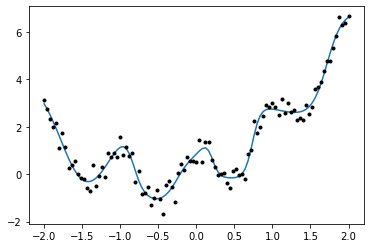

In [7]:
plt.plot(x.detach().squeeze(),y_pred.detach().squeeze())
plt.plot(x.detach().squeeze(),y_obs.detach().squeeze(),'k.')

# Your task:
Train a neural on MNIST using pytorch.  You should use the above code as a template.  Things you'll need to change: $n$ will no longer be 1, but rather 784.  $N$ will no longer be one, but 10.  You'll want to adjust $p$, the number of hidden layer nodes.  You'll likely need to adjust the learning rate.  Finally, and most importantly, you'll need to use a different loss function.  In particular, you'll replace our handrolled MSE code with [this](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).  IMPORTANT NOTE: this loss expects *logits* as inputs, which is to say that it will do softmax for you internally.  As such, the architecture of your network should be more or less the same as above.  